In [ ]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

import pickle

from arviz import psislw
from scipy.special import logsumexp

from amortizer import amortizer, trainer
from src.models.HmmEam import unconstrain_parameters

from pandas import read_csv

from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_100.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
stan_model = CmdStanModel(stan_file="../../stan/hmm-eam.stan")

DEBUG:cmdstanpy:found newer exe file, not recompiling


In [ ]:
def plot_weighted_posterior(background, foreground, weights, param_names, label="Log-Posterior"):
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    for i in range(8):
        axes[0,i].set_title(param_names[i])
        axes[i,0].set_ylabel(param_names[i])
        for j in range(8):
            ax = axes[i, j]
            if i == j:
                ax.hist(background[:,i], color="gray", alpha=0.7, bins=25)
                ax.hist(foreground[:, i], color="blue", alpha=0.7, bins=25)
            else:
                # Off-diagonal: Scatter plot with gradient color by weights
                ax.scatter(background[:,j], stan_posterior[:,i], alpha=0.5, c="gray", s=2.5)
                sc = ax.scatter(foreground[:, j], foreground[:, i], c=weights, cmap=cm.viridis, alpha=0.7, s=2.5)

            # Hide axis labels to keep the plot cleaner
            ax.set_xticks([])
            ax.set_yticks([])

    # Add a color bar for weight gradient
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position the color bar to the right
    fig.colorbar(sc, cax=cbar_ax, label=label)

def get_summary_conditions(rts, choice):
    responses = tf.one_hot(choice-1, 2)

    summary_conditions = tf.concat([rts, responses], axis=-1)
    summary_conditions = tf.expand_dims(summary_conditions, axis=0)

    return summary_conditions

def configure_data(subject):
    path = os.path.join('dutilh-resources', 'data', subject) + '.csv'
    df = read_csv(path)
    df = np.array(df)
    df = df[:400,...]

    rts = df[:,1:2].astype(np.float32)
    choice = np.abs(df[:,2]-3)

    output = {
        "stan_inputs": {
            "n_obs": len(rts),
            "y": [(int(c), r) for c, r in zip(choice, rts[:,0])]
        },
        "rt": rts[:,0],
        "choice": choice,
        "summary_conditions": get_summary_conditions(rts, choice)
    }
    return output

In [ ]:
# let's try a subject where Stan and BayesFlow actually agrees
subject = "subject-c"

In [5]:
df = configure_data(subject)

In [6]:
path = os.path.join('dutilh-resources', 'bayesflow-fits', subject) + '.pkl'
with open(path, 'rb') as f:
    bf_posterior_constrained, _ = pickle.load(f)

In [7]:
path = os.path.join('dutilh-resources', 'stan-fits', subject) + '.pkl'
with open(path, 'rb') as f:
    stan_fit = pickle.load(f)

stan_posterior = np.array([
    stan_fit.stan_variable('transition_matrix')[:, 0, 0],
    stan_fit.stan_variable('transition_matrix')[:, 1, 1],
    stan_fit.stan_variable('alpha_1'),
    stan_fit.stan_variable('alpha_2'),
    stan_fit.stan_variable('nu_1'),
    stan_fit.stan_variable('nu_2')[:,0],
    stan_fit.stan_variable('nu_2')[:,1],
    stan_fit.stan_variable('tau'),
    ]).transpose()

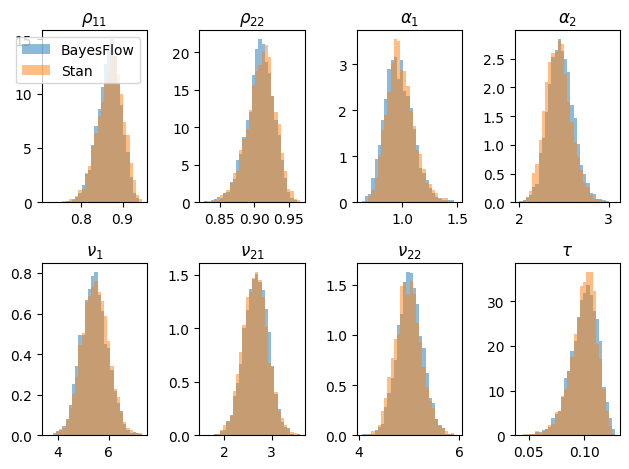

In [8]:
def plot_marginal_posteriors(stan, bayesflow, param_names):

    fig, axs = plt.subplots(ncols=4, nrows=2)
    axs = axs.flatten()

    bins = [
        np.linspace(np.min(bayesflow[:,i]), np.max(bayesflow[:,i]), 31) for i in range(len(param_names))
    ]
    for i, par in enumerate(param_names):
        axs[i].hist(bayesflow[:,i], bins = bins[i], alpha=0.5, density=True, label = "BayesFlow")
        axs[i].hist(stan[:,i], bins = bins[i], alpha=0.5, density=True, label = "Stan")
        axs[i].set_title(par)

    axs[0].legend()
    fig.tight_layout()

    return fig, axs


f=plot_marginal_posteriors(stan_posterior, bf_posterior_constrained[0], trainer.generative_model.param_names['constrained'])

In [32]:
bf_posterior_unconstrained = unconstrain_parameters(bf_posterior_constrained, rts=np.min(df['rt']))
stan_posterior_unconstrained = unconstrain_parameters(stan_posterior, rts=np.min(df['rt']))

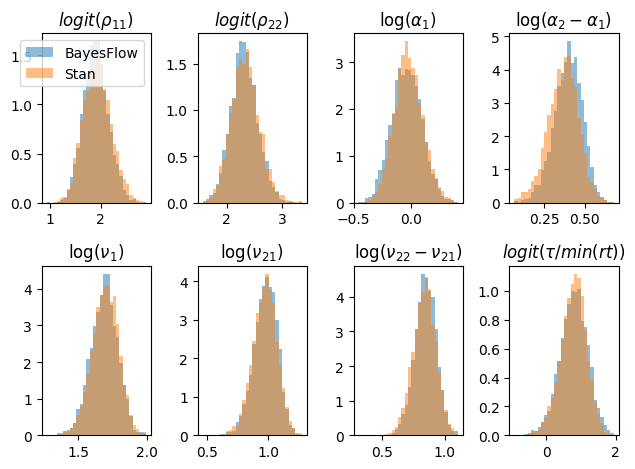

In [34]:
f=plot_marginal_posteriors(stan_posterior_unconstrained, bf_posterior_unconstrained[0], trainer.generative_model.param_names['unconstrained'])

In [ ]:
# calculate log-prob according to BayesFlow
bf_inputs = {
    "summary_conditions": df['summary_conditions'],
    "parameters": bf_posterior_unconstrained
}
bf_log_prob = amortizer.amortized_posterior.log_prob(bf_inputs)
bf_log_prob = bf_log_prob[0]
f=plt.plot(bf_log_prob)

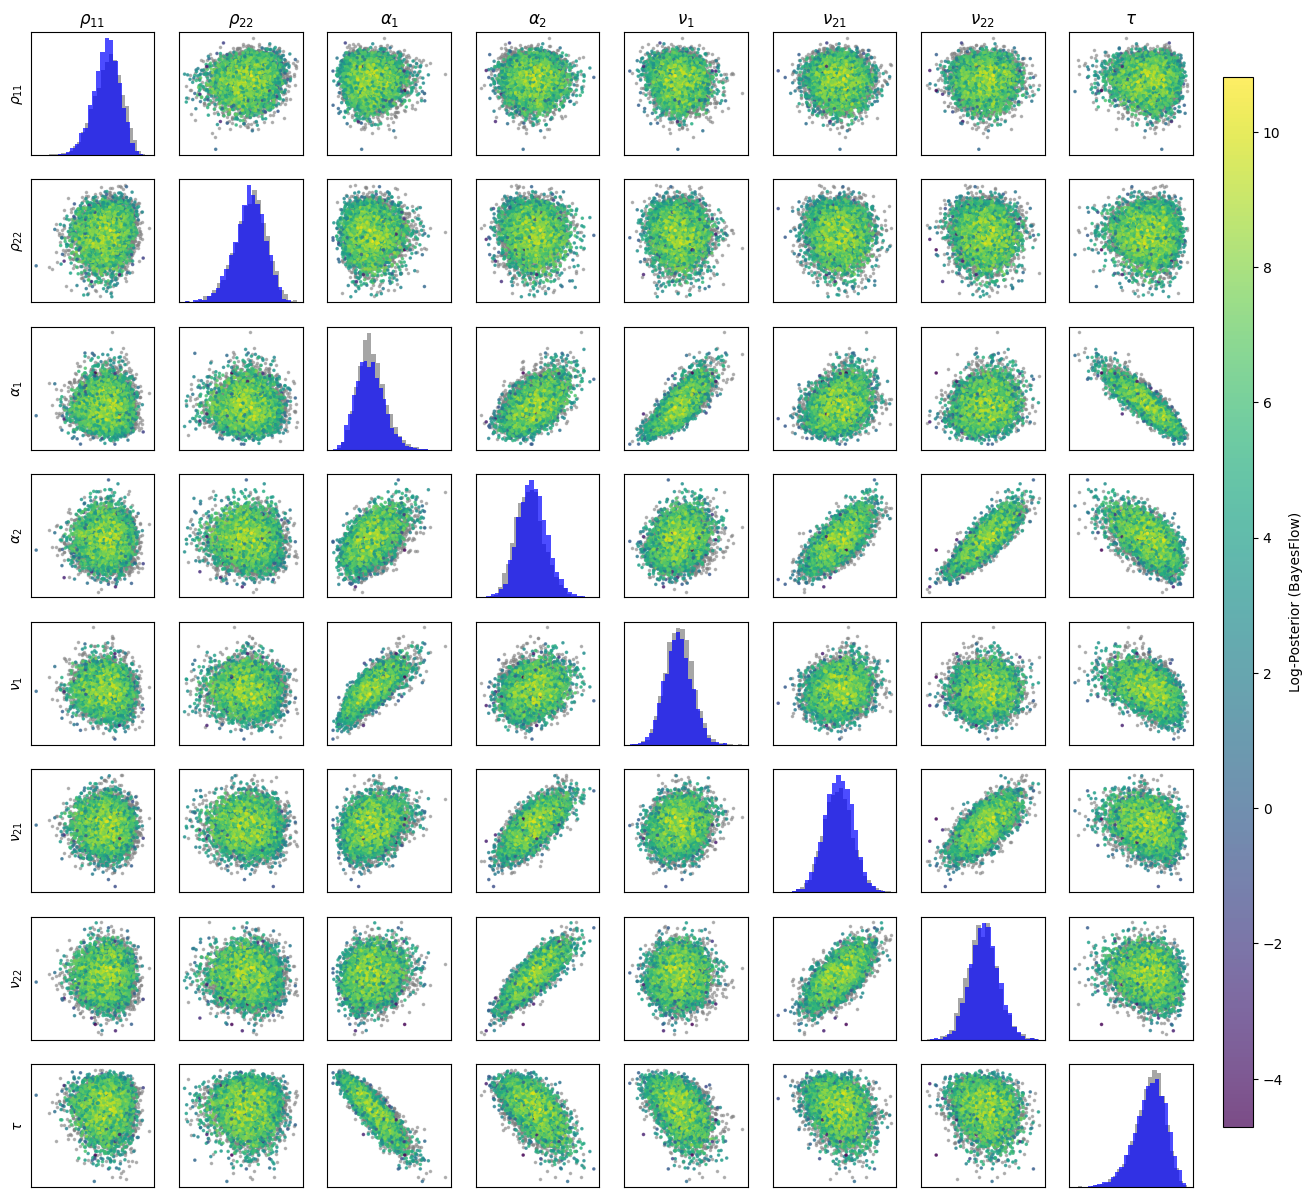

In [ ]:
# plot the posterior with log-density highlighted by color
# brighter colors should be mostly in the middle
plot_weighted_posterior(background=stan_posterior, foreground=bf_posterior_constrained[0], weights=bf_log_prob, param_names=trainer.generative_model.param_names['constrained'], label="Log-Posterior (BayesFlow)")

In [42]:
# Calculate log-prob using the Stan program
stan_log_prob = []

for iter in range(bf_posterior_constrained.shape[1]):
    post = bf_posterior_constrained[0,iter]

    transition_matrix = np.array([[post[0], 1-post[0]],
                                  [1-post[1], post[1]]])
    
    stan_params = {
        "transition_matrix": transition_matrix,
        "alpha_1": post[2],
        "alpha_2_diff": post[3],
        "nu_1": post[4],
        "nu_21": post[5],
        "nu_22_diff": post[6],
        "tau": post[7]
        }
    
    lp = stan_model.log_prob(params = stan_params, data = df['stan_inputs'], jacobian=True)

    stan_log_prob.append(np.array(lp)[0,0])

stan_log_prob = np.array(stan_log_prob)
f=plt.plot(stan_log_prob)

DEBUG:cmdstanpy:cmd: /Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/hmm-eam info
cwd: None
DEBUG:cmdstanpy:input tempfile: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1rxj7c2r/2aabk621.json
DEBUG:cmdstanpy:input tempfile: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1rxj7c2r/73d2ub0d.json
DEBUG:cmdstanpy:Cmd: ['/Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/hmm-eam', 'log_prob', 'constrained_params=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1rxj7c2r/73d2ub0d.json', 'jacobian=1', 'data', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1rxj7c2r/2aabk621.json', 'output', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1rxj7c2r/hmm-eamac52sv8k/output.csv']
DEBUG:cmdstanpy:cmd: /Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/hmm-eam info
cwd: None
DEBUG:cmdstanpy:input tempfile: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1rxj7c2r/875cx0v3.json
DEBUG:cmdstanpy:input tempfile: /var/folders/v

(4000,)

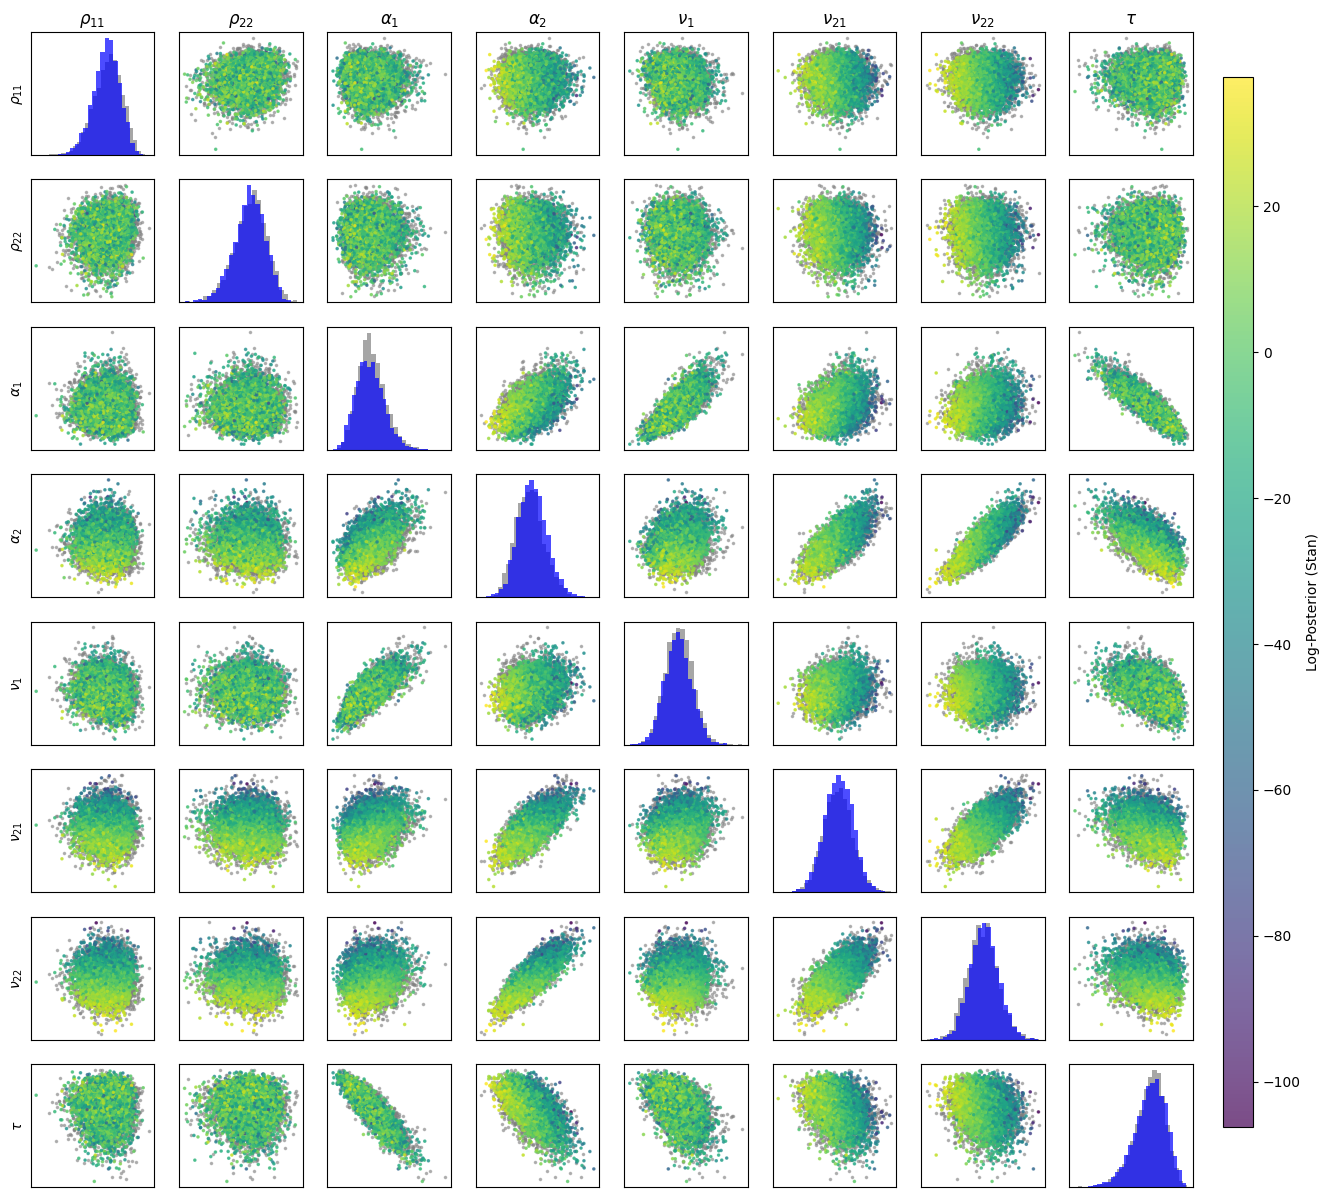

In [ ]:
# using the stan log posterior density is slanted: samples on the edge of the posterior are getting higher densities...
plot_weighted_posterior(background=stan_posterior, foreground=bf_posterior_constrained[0], weights=stan_log_prob, param_names=trainer.generative_model.param_names['constrained'], label="Log-Posterior (Stan)")

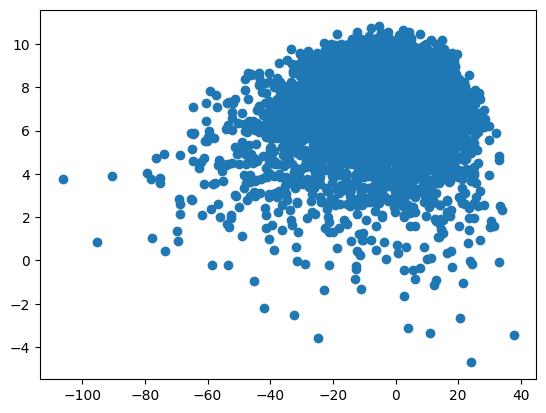

In [43]:
f=plt.scatter(stan_log_prob, bf_log_prob)

In [ ]:
importance_weights = stan_log_prob - bf_log_prob
pareto_weights, pareto_k = psislw(np.copy(importance_weights))
print("Pareto k = ", pareto_k) # not good

Pareto k =  4.300544547237507


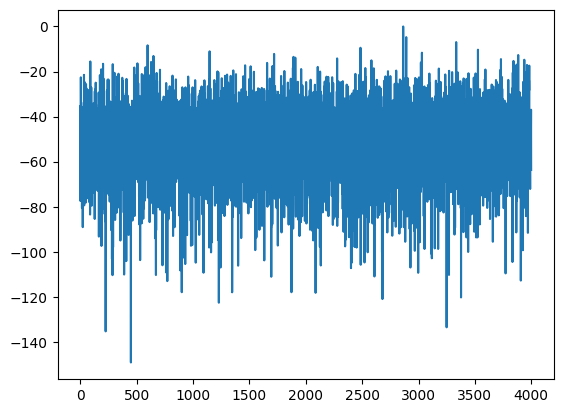

In [45]:
f=plt.plot(pareto_weights)

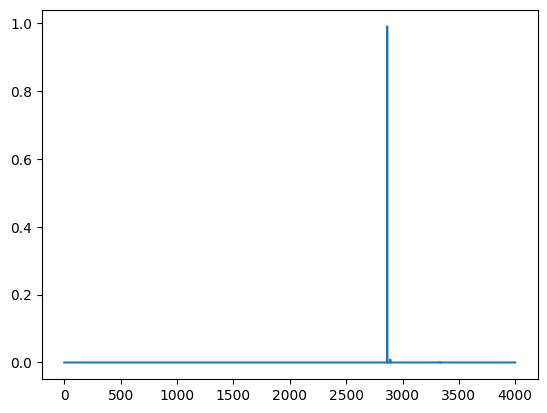

In [46]:
f=plt.plot(np.exp(pareto_weights))

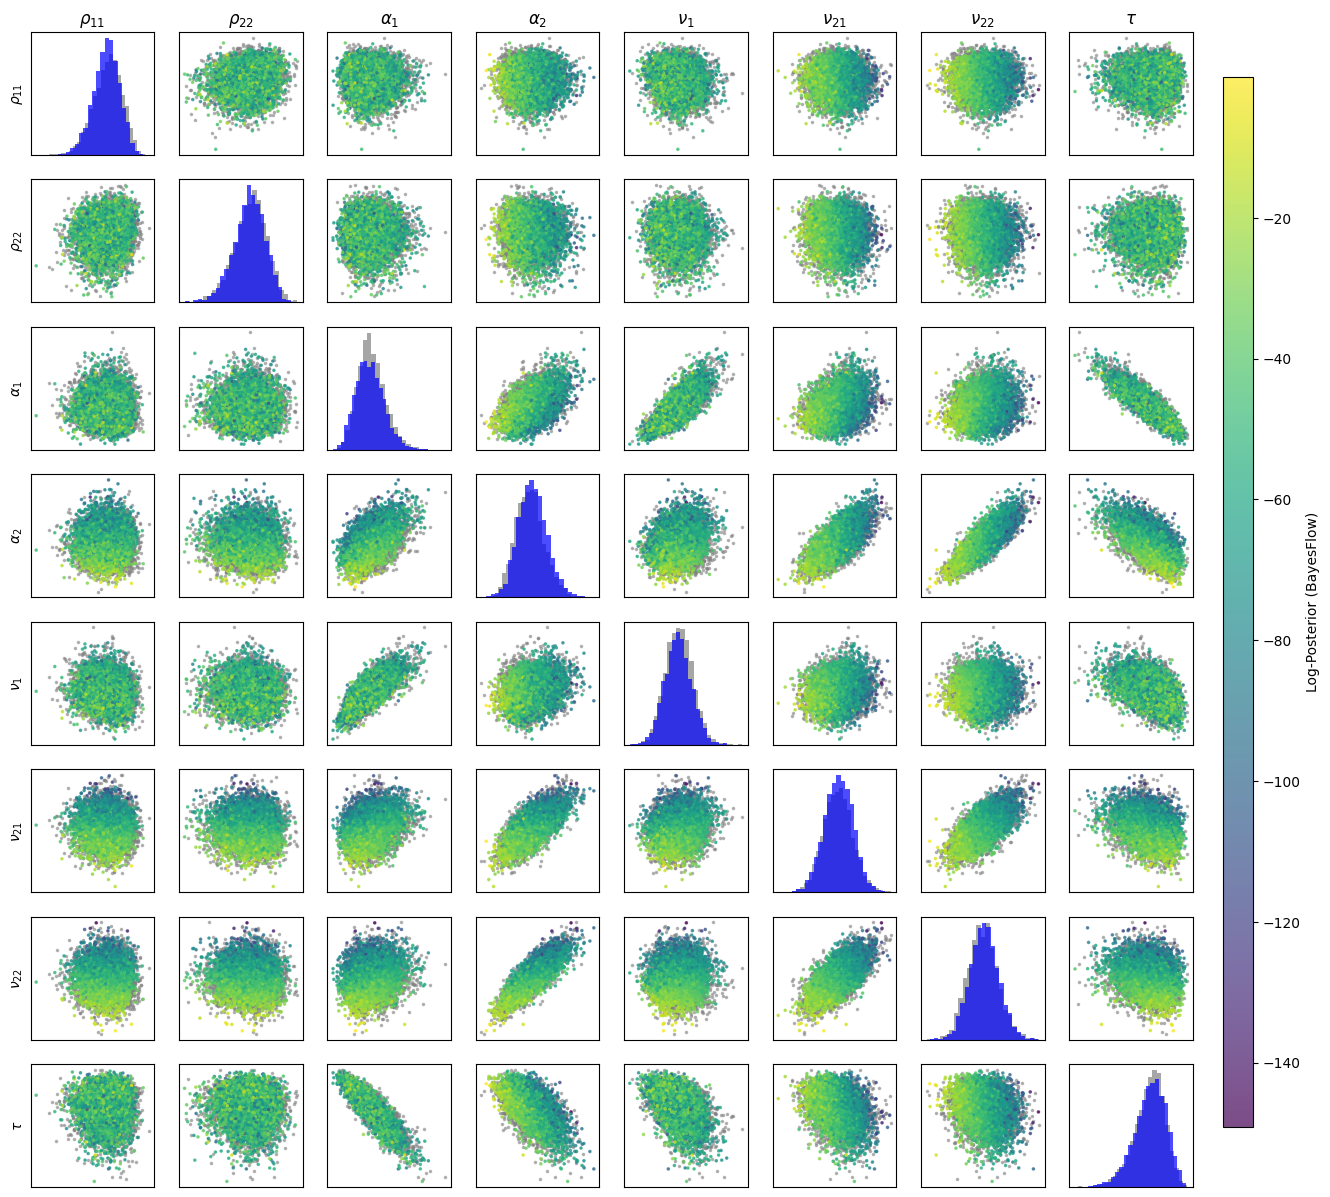

In [ ]:
# the pareto-smoothed importance weights are slanted due to the Stan densities
plot_weighted_posterior(background=stan_posterior, foreground=bf_posterior_constrained[0], weights=pareto_weights, param_names=trainer.generative_model.param_names['constrained'], label="Pareto weights")